<div align="center">

<h1> Object Detection with YOLOv8  <a target="_blank" href="https://colab.research.google.com/github/Marconi-Lab/dsa_2024/blob/main/dsa2024_yolov8_detection.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img width="1024" src="https://user-images.githubusercontent.com/26833433/243418624-5785cb93-74c9-4541-9179-d5c6782d491a.png">
</div>

Object detection is a task that involves identifying the location and class of objects in an image or video stream.
The output of an object detector is a set of bounding boxes that enclose the objects in the image, along with class labels and confidence scores for each box. Object detection is a good choice when you need to identify objects of interest in a scene, but don't need to know exactly where the object is or its exact shape.


This walkthrough covers:
 - Setting up the tools necessary for object detection tasks
 - EDA Exploration in the context of computer vision
 - Zero shot object detection using YOLO-World
 - Fine tuning YOLOv8 with a custom dataset
 - Evaluating Performance of Object Detection Models

**Computer vision in camera trapping**  
Camera traps are motion activated camera traps often deployed in conservancies to capture images of animals in their natural habitats without human intervention. They are used by conservationists to monitor biodiversity, track population trends, study animal behaviours, and assess the impact of environmental changes on wildlife habitats. Camera traps deployed in active locations such as animal corridors can generate enormous amounts of data. This can limit how much the ecologists can utilize the camera trap data to study the ecosystems.
Object detection algorithms can be applied to camera trap datasets to automate the process of species identification.
This allows researchers to efficiently study large areas
Overall, object detection enhances the effectiveness and scalability of camera trap-based research, providing researchers with powerful tools to advance wildlife conservation efforts and promote sustainable management practices.

Working with camera trap datasets presents several unique challenges. One significant challenge is the sheer volume of data generated by camera traps, often spanning extensive time periods and multiple locations. Additionally, camera trap images are often captured under variable lighting conditions and environmental settings, leading to variations in image quality and clarity. Furthermore, camera traps may capture multiple animals in a single frame, leading to occlusions and overlaps. Another challenge is the need for species-specific training data to develop accurate object detection models, which may be limited or unavailable for rare or less studied species.

In this notebook, we will look at how object detection algorithms can be used to detect and classify animals in camera trap datasets.

## Install and Setup

In this section we are going to install and set up some of the tools we are going to use:
1. [Ultralytics](https://docs.ultralytics.com)

Ultralytics is the home for state-of-the-art computer vision models for tasks like image classification, object detection, image segmentation, and pose estimation. It hosts YOLOv8, the latest iteration in the YOLO series of real-time object detection models, as well as other powerful computer vision models such as SAM (Segment Anything Model), RT-DETR, YOLO-NAS, etc. Besides providing implementations of these models, Ultralytics also provides us with out-of-the-box workflows for training, fine-tuning, and applying these models using an easy-to-use API.

2. [Supervision](https://supervision.roboflow.com/latest/)

Supervision is a utility tool developed by Roboflow that can be used to annotate images with bounding boxes, track or count objects in videos and even calculate detection metrics of a model.

3. [Fiftyone](https://docs.voxel51.com/)

Fiftyone is a tool that is used to curate and visualize image and video datasets and to evaluate trained models visually by inspecting the failure modes of the models.

4. [Data-Gradients](https://github.com/Deci-AI/data-gradients/)

Data-Gradients is a computer vision exploratory data analysis tool. It can extract valuable insights from image datasets and give comprehensive reports on the general dataset overview such as the general image metrics, classes overview, class frequencies and distributions and bounding box/mask details.

5. [Roboflow](https://roboflow.com/)

Roboflow is a hub of that offers a range of computer vision tools. It also provides a platform to annotate computer vision datasets and host them.

### Install necessary packages

In [ ]:
## Install necessary packages
## Supervision : for visualizing the detected and the ground-truth bounding boxes
!pip install supervision &>1
print('Finished installing supervision')

## Roboflow : To download our annotated custom dataset
!pip install roboflow &>1
print('Finished installing roboflow')

## Ultralytics : for modelling
!pip install ultralytics &>1
print('Finished installing ultralytics')

## Fiftyone : to visually inspect the dataset bounding boxes and predictions
!pip install fiftyone &>1
print('Finished installing fiftyone')

## Data-Gradients : for eda
!pip install data-gradients &>1
print('Finished installing data-gradients')


Finished installing supervision
Finished installing roboflow
Finished installing ultralytics
Finished installing fiftyone
Finished installing data-gradients


### Import the packages

In [ ]:
import ultralytics
from ultralytics import YOLO
from roboflow import Roboflow
import fiftyone as fo
import fiftyone.brain as fob
from PIL import Image
import supervision as sv
import random
import os
from pathlib import Path
from IPython.display import clear_output

Migrating database to v0.23.8


INFO:fiftyone.migrations.runner:Migrating database to v0.23.8


In [ ]:
## Check that the T4 GPU is enabled
from ultralytics import checks
checks()

Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 31.0/78.2 GB disk)


### Download Roboflow Dataset

To download the annotated dataset on Roboflow, we are going to need an API key. If you are signed up on Roboflow, you should already have the key. In case you do not have the key, now is the time to sign up on the platform since we are going to be using it extensively on this notebook. To access your private API key, click the settings icon and then on 'Roboflow API' button.

Here, I have used the handy Colab Secrets feature to avoid exposing my private API key. If you are using Colab, go ahead and copy the key and add it to your secrets.(Click on the Key button on the left pane to open the secrets window)
![]()

The dataset we are going to use is an annotated subset of the [DSAIL-Porini](https://www.sciencedirect.com/science/article/pii/S2352340922010666), a camera trap dataset collected and curated by Lorna Mugambi et al at the Dedan Kimathi University Conservancy. The dataset contains five species of animals. The train split version we are importing from Roboflow has already been augmented while the validation and test splits contain unaugmented images

In [ ]:
from google.colab import userdata
roboflow_api = userdata.get('roboflow_api')

In [ ]:
rf = Roboflow(api_key=roboflow_api)
project = rf.workspace("mltowardsobb").project("dsail-porini-detection-v2")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.16, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to dsail-porini-detection-v2-1 in yolov8:: 100%|██████████| 2338/2338 [00:00<00:00, 5152.86it/s]


In [ ]:
## Check the dataset size
!du -h /content/dsail-porini-detection-v2-1

4.3M	/content/dsail-porini-detection-v2-1/train/labels
34M	/content/dsail-porini-detection-v2-1/train/images
38M	/content/dsail-porini-detection-v2-1/train
292K	/content/dsail-porini-detection-v2-1/valid/labels
2.4M	/content/dsail-porini-detection-v2-1/valid/images
2.7M	/content/dsail-porini-detection-v2-1/valid
188K	/content/dsail-porini-detection-v2-1/test/labels
1.5M	/content/dsail-porini-detection-v2-1/test/images
1.7M	/content/dsail-porini-detection-v2-1/test
43M	/content/dsail-porini-detection-v2-1


## Dataset Exploration

### Visual Exploration with Fiftyone

In [65]:
from IPython.display import Video
Video("https://raw.githubusercontent.com/Marconi-Lab/dsa_2024/main/assets/fiftyone-screencast-1.webm")


Before we can begin our dataset exploration we need to create a file called `dataset.yaml` that contains information about the dataset we just downloaded from Roboflow. The dataset is structured in the yolo format which has this structure :

```
dataset_root/
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── val
    ├── images
    └── labels

```
A `yaml` file is used to specify the class names, the directory where the dataset is located and the relative paths to the `train`, `validation` and `test` images.
The yaml file that comes with the dataset is not configured well and for our own convenience, we create a new yaml file. Run the cell below to create the new yaml file.

In [ ]:
%%writefile dsail-porini-detection-v2-1/dataset.yaml
names:
 0 : bushbuck
 1 : impala
 2 : monkey
 3 : warthog
 4 : waterbuck
 5 : zebra

nc: 6
test: test/images
train: train/images
val: valid/images

Writing dsail-porini-detection-v2-1/dataset.yaml


In [ ]:
from fiftyone.utils.yolo import YOLOv5DatasetImporter
train_importer = YOLOv5DatasetImporter(
    dataset_dir='/content/dsail-porini-detection-v2-1',
    yaml_path=None,
    split='train',
    label_type='detections',
    include_all_data=True,
    shuffle=True,
    seed=51,
    max_samples=None)

val_importer = YOLOv5DatasetImporter(
    dataset_dir='/content/dsail-porini-detection-v2-1',
    split='val',
    shuffle=True,
    seed=51)

test_importer = YOLOv5DatasetImporter(
    dataset_dir='/content/dsail-porini-detection-v2-1',
    split='test',
    shuffle=True,
    seed=51)

In [ ]:
train_dataset = fo.Dataset.from_importer(train_importer, name='dsail-porini train')
val_dataset = fo.Dataset.from_importer(val_importer, name='dsail-porini val')
test_dataset = fo.Dataset.from_importer(test_importer, name='dsail-porini test')

 100% |███████████████| 1047/1047 [1.4s elapsed, 0s remaining, 765.7 samples/s]         


INFO:eta.core.utils: 100% |███████████████| 1047/1047 [1.4s elapsed, 0s remaining, 765.7 samples/s]         


 100% |███████████████████| 70/70 [108.2ms elapsed, 0s remaining, 647.2 samples/s] 


INFO:eta.core.utils: 100% |███████████████████| 70/70 [108.2ms elapsed, 0s remaining, 647.2 samples/s] 


 100% |███████████████████| 46/46 [81.8ms elapsed, 0s remaining, 562.7 samples/s]  


INFO:eta.core.utils: 100% |███████████████████| 46/46 [81.8ms elapsed, 0s remaining, 562.7 samples/s]  


In [ ]:
combined_dataset = fo.Dataset(name='combined_dataset', overwrite=True)
for importer in [train_importer, test_importer, val_importer]:
  sub_dataset = fo.Dataset.from_importer(importer, overwrite=True)
  combined_dataset.merge_samples(sub_dataset)

combined_dataset

 100% |███████████████| 1047/1047 [2.0s elapsed, 0s remaining, 516.2 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1047/1047 [2.0s elapsed, 0s remaining, 516.2 samples/s]      


 100% |███████████████████| 46/46 [156.3ms elapsed, 0s remaining, 316.7 samples/s] 


INFO:eta.core.utils: 100% |███████████████████| 46/46 [156.3ms elapsed, 0s remaining, 316.7 samples/s] 


 100% |███████████████████| 70/70 [115.2ms elapsed, 0s remaining, 607.9 samples/s] 


INFO:eta.core.utils: 100% |███████████████████| 70/70 [115.2ms elapsed, 0s remaining, 607.9 samples/s] 


Name:        combined_dataset
Media type:  image
Num samples: 1163
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)

In [ ]:
## Compute the metadata such as image size, mime type, num of channels and path for the dataset splits
train_dataset.compute_metadata()
val_dataset.compute_metadata()
test_dataset.compute_metadata()
combined_dataset.compute_metadata()

Computing metadata...


INFO:fiftyone.core.metadata:Computing metadata...


 100% |███████████████| 1047/1047 [466.1ms elapsed, 0s remaining, 2.2K samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1047/1047 [466.1ms elapsed, 0s remaining, 2.2K samples/s]      


Computing metadata...


INFO:fiftyone.core.metadata:Computing metadata...


 100% |███████████████████| 70/70 [26.9ms elapsed, 0s remaining, 2.6K samples/s] 


INFO:eta.core.utils: 100% |███████████████████| 70/70 [26.9ms elapsed, 0s remaining, 2.6K samples/s] 


Computing metadata...


INFO:fiftyone.core.metadata:Computing metadata...


 100% |███████████████████| 46/46 [19.6ms elapsed, 0s remaining, 2.3K samples/s] 


INFO:eta.core.utils: 100% |███████████████████| 46/46 [19.6ms elapsed, 0s remaining, 2.3K samples/s] 


Computing metadata...


INFO:fiftyone.core.metadata:Computing metadata...


 100% |███████████████| 1163/1163 [625.2ms elapsed, 0s remaining, 1.9K samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1163/1163 [625.2ms elapsed, 0s remaining, 1.9K samples/s]      


In [ ]:
session = fo.launch_app(train_dataset, auto=False)

Session launched. Run `session.show()` to open the App in a cell output.


INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.



Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.23.8

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



INFO:fiftyone.core.session.session:
Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.23.8

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



In [ ]:
## Install umap-learn to use to compute 2D embeddings for the dataset
!pip install umap-learn &>1

# Compute 2D representation
# This will compute deep embeddings for all images
results = fob.compute_visualization(
    combined_dataset,
    num_dims=2,
    method='umap',
    brain_key="Viz_2D",
    verbose=True,
    seed=51,
)

INFO:fiftyone.core.models:Downloading model from 'https://download.pytorch.org/models/mobilenet_v2-b0353104.pth'...


 100% |████|  108.4Mb/108.4Mb [303.8ms elapsed, 0s remaining, 356.9Mb/s]      


INFO:eta.core.utils: 100% |████|  108.4Mb/108.4Mb [303.8ms elapsed, 0s remaining, 356.9Mb/s]      
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 15.3MB/s]


Computing embeddings...


INFO:fiftyone.brain.internal.core.utils:Computing embeddings...


 100% |███████████████| 1163/1163 [21.7s elapsed, 0s remaining, 62.6 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1163/1163 [21.7s elapsed, 0s remaining, 62.6 samples/s]      


Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


UMAP(n_jobs=1, random_state=51, verbose=True)
Thu May 16 11:46:08 2024 Construct fuzzy simplicial set
Thu May 16 11:46:09 2024 Finding Nearest Neighbors
Thu May 16 11:46:14 2024 Finished Nearest Neighbor Search
Thu May 16 11:46:18 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu May 16 11:46:21 2024 Finished embedding


In [ ]:
## Look through the images
## Note that this cell may take a while to load and render the Fiftyone app
session.show()

In [ ]:
## Freeze a screenshot of the session
session.freeze()

In [ ]:
class_names = train_dataset.default_classes
class_names

['bushbuck', 'impala', 'monkey', 'warthog', 'waterbuck', 'zebra']

### Data-Gradients Profile Report

Next, we are going to use the `Data-Gradients` package that will profile our dataset and generate an extensive report in PDF format. You can download the generated report document and read it offline to get deep insights into the dataset.

To generate `Data-Gradients` report, run the cell below. Note that you will be required to answer a few questions in the interactive shell in order for the report to be generated.

To help guide you :

 1) The images are in `RGB` format

 2) The dataset annotations are in YOLO format where the Label comes first ie. [class_id, x1, y1, w, h]

 3) The YOLO bounding box format is as follows : `cxcywh: x-center, y-center, width, height`

  - Executing analysis with: 
  - batches_early_stop: None 
  - len(train_data): 1047 
  - len(val_data): 70 
  - log directory: /content/logs/DSAIL-Porini_Detection_Exploration 
  - Archive directory: /content/logs/DSAIL-Porini_Detection_Exploration/archive_20240516-120150 
  - feature extractor list: {'Image Features': [SummaryStats, ImagesResolution, ImageColorDistribution, ImagesAverageBrightness], 'Object Detection Features': [DetectionClassHeatmap, DetectionBoundingBoxArea, DetectionBoundingBoxPerImageCount, DetectionBoundingBoxSize, DetectionClassFrequency, DetectionClassesPerImageCount, DetectionBoundingBoxIoU, DetectionResizeImpact]}
╔══════════════════════════════════════════════════════════════════════════╗
║  To better understand how to tackle the data issues highlighted in this  ║
║  report, explore our comprehensive course on analyzing computer vision   ║
║  datasets. click here: https://hubs.ly/Q01XpHBT0                         ║
╚════════════════════════════════════════

Analyzing... :   0%|          | 0/1047 [00:00<?, ?it/s]


--------------------------------------------------------------------------------
In which format are your images loaded ?
--------------------------------------------------------------------------------

Options:
[0] | RGB
[1] | BGR
[2] | LAB
[3] | Other

Your selection (Enter the corresponding number) >>> 0
Great! You chose: `RGB`

--------------------------------------------------------------------------------
Which comes first in your annotations, the class id or the bounding box?
--------------------------------------------------------------------------------
Here's a sample of how your labels look like:
Each line corresponds to a bounding box.
tensor([[3.0000, 0.4781, 0.5000, 0.6094, 1.0000]], dtype=torch.float64)
Options:
[0] | Label comes first (e.g. [class_id, x1, y1, x2, y2])
[1] | Bounding box comes first (e.g. [x1, y1, x2, y2, class_id])

Your selection (Enter the corresponding number) >>> 0
Great! You chose: `Label comes first (e.g. [class_id, x1, y1, x2, y2])`

----------

Analyzing... :   0%|          | 1/1047 [00:26<7:43:20, 26.58s/it]

Great! You chose: `cxcywh: x-center, y-center, width, height		(YOLO format)`


Summarizing... :  50%|█████     | 1/2 [00:02<00:02,  2.18s/it]FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.4`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.


The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.4`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

Summarizing... : 100%|██████████| 2/2 [00:14<00:00,  7.25s/it]


Dataset successfully analyzed!
Starting to write the report, this may take around 10 seconds...

Your dataset evaluation has been completed!

----------------------------------------------------------------------------------------------------
Training Configuration...
`DetectionDataConfig` cache is not enabled because `cache_path=None` was not set.

----------------------------------------------------------------------------------------------------
Report Location:
    - Temporary Folder (will be overwritten next run):
        └─ /content/logs/DSAIL-Porini_Detection_Exploration
                ├─ Report.pdf
                └─ summary.json
    - Archive Folder:
        └─ /content/logs/DSAIL-Porini_Detection_Exploration/archive_20240516-120150
                ├─ Report.pdf
                └─ summary.json

Seen a glitch? Have a suggestion? Visit https://github.com/Deci-AI/data-gradients !


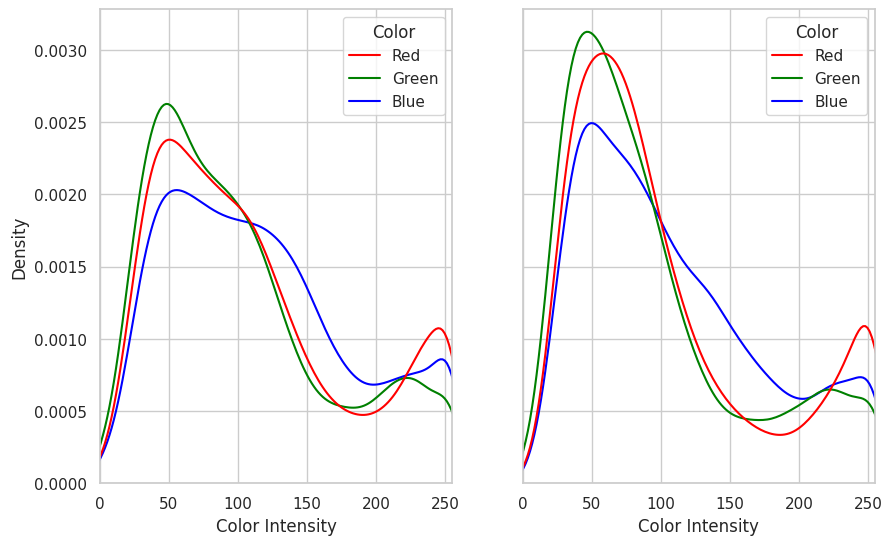

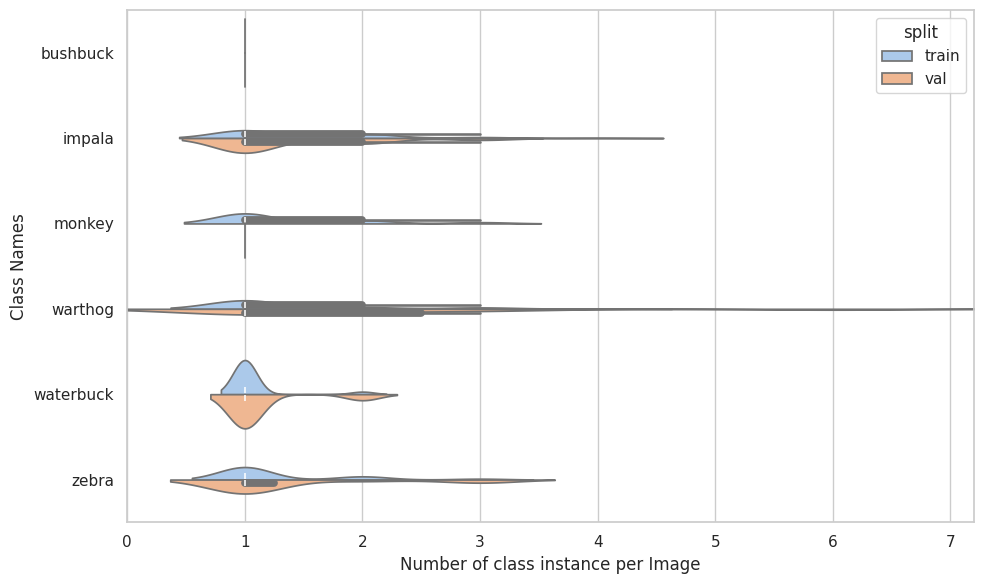

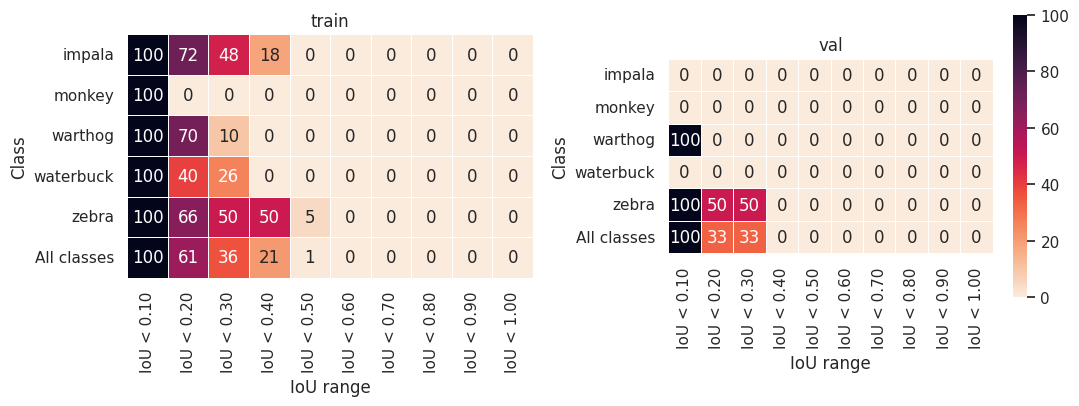

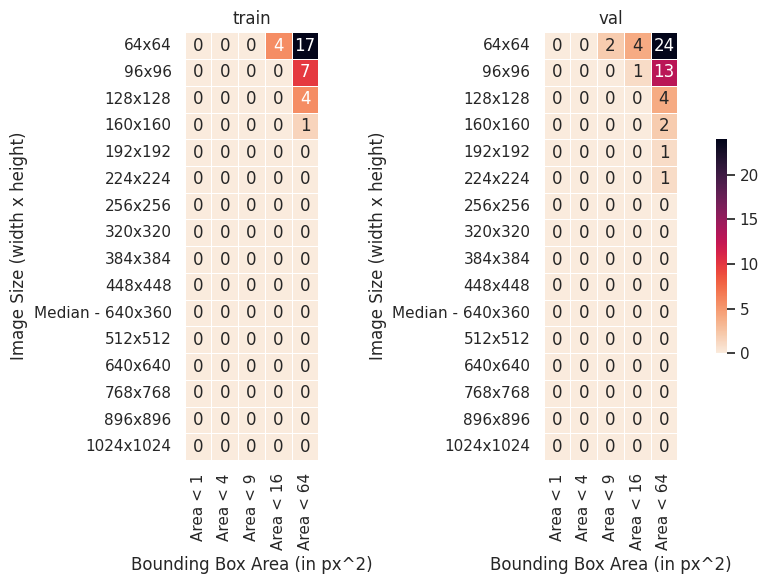

In [ ]:
from data_gradients.managers.detection_manager import DetectionAnalysisManager
from data_gradients.datasets.detection import YoloFormatDetectionDataset

train_loader = YoloFormatDetectionDataset(root_dir="/content/dsail-porini-detection-v2-1", images_dir="train/images", labels_dir="train/labels")
val_loader = YoloFormatDetectionDataset(root_dir="/content/dsail-porini-detection-v2-1", images_dir="valid/images", labels_dir="valid/labels")

class_names = train_dataset.default_classes

da = DetectionAnalysisManager(
    report_title="DSAIL-Porini Detection Exploration",
    train_data=train_loader,
    val_data=val_loader,
    class_names=class_names,
)

da.run()

 The generated report is saved in the path `/content/logs/DSAIL-Porini_Detection_Exploration/Report.pdf`. Run the cell below to download the pdf report.
To understand the significance of each component of the report and how it can guide your modelling approach, you can go through this [short course](https://deci.ai/course/profiling-computer-vision-datasets-overview/) by the creators of Data-Gradients

In [ ]:
from google.colab import files
files.download('/content/logs/DSAIL-Porini_Detection_Exploration/Report.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Zero-Shot Learning with YOLO-World

The [YOLO-World Model](https://docs.ultralytics.com/models/yolo-world/) is an advanced, real-time YOLOv8-based Open-Vocabulary Detection model available on Ultralytics. The YOLO-World framework allows for the dynamic specification of classes through custom prompts, empowering users to tailor the model to their specific needs without retraining. This feature is particularly useful for adapting the model to new domains or specific tasks that were not originally part of the training data. By setting custom prompts, users can essentially guide the model's focus towards objects of interest, enhancing the relevance and accuracy of the detection results.

In [ ]:
from ultralytics import YOLOWorld

# Initialize YOLO-World model
model = YOLOWorld('yolov8s-world.pt')  # select yolov8m-world.pt or yolov8l-world.pt for different sizes

# Define custom classes
model.set_classes(['bushbuck', 'impala', 'monkey', 'warthog', 'waterbuck', 'zebra'])

100%|██████████| 25.9M/25.9M [00:00<00:00, 326MB/s]

requirements: Ultralytics requirement ['git+https://github.com/ultralytics/CLIP.git'] not found, attempting AutoUpdate...


  Cloning https://github.com/ultralytics/CLIP.git to /tmp/pip-req-build-4rk7dzi2
  Resolved https://github.com/ultralytics/CLIP.git to commit e17416a36b45d040758327936a1ea150c13fe3d1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369504 sha256=03ddc6a17d3a13d6d14563e305ea86fdd9de88e83d57ac59a4006610bd19666b
  Stored in directory: /tmp/pip-ephem-wheel-cache-8tbnhqgz/wheels/2e/25/92/e26f2a227599930e19a8188891e9600b6dd36721a0f8d6ef40
Successfully built clip

requirements: AutoUpdate success ✅ 12.4s, installed 1 package: ['git+https://github.com/ultralytics/CLIP.git']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 87.9MiB/s]


In [ ]:
model.names

{0: 'bushbuck',
 1: 'impala',
 2: 'monkey',
 3: 'warthog',
 4: 'waterbuck',
 5: 'zebra'}

In [ ]:
## Select a few sample random images to run inference on
random.seed(42) # Set random seed for reproducibility
images = sorted(Path.rglob(Path('/content/dsail-porini-detection-v2-1/valid'), '*.jpg'))
sample_images = random.sample(images, 9)

In [ ]:
## Make predictions on the sample images
results = model.predict(sample_images)

## Save output images with bounding boxes in a folder
os.makedirs('results', exist_ok=True)
for result in results:
  result_path = os.path.join('results', os.path.basename(result.path))
  result.save(result_path)


0: 384x640 1 waterbuck, 9.2ms
1: 384x640 1 waterbuck, 9.2ms
2: 384x640 (no detections), 9.2ms
3: 384x640 (no detections), 9.2ms
4: 384x640 (no detections), 9.2ms
5: 384x640 1 zebra, 9.2ms
6: 384x640 1 waterbuck, 9.2ms
7: 384x640 (no detections), 9.2ms
8: 384x640 (no detections), 9.2ms
Speed: 1.0ms preprocess, 9.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


In [ ]:
def visualize_directory_images(dir, grid_size=(2,2)):
  num_images = grid_size[0] * grid_size[1]
  image_size = (grid_size[0]*3, grid_size[1]*7)
  image_names = os.listdir(dir)[:num_images]
  image_paths = [os.path.join(dir, i) for i in image_names]
  images = [Image.open(i) for i in image_paths]
  sv.plot_images_grid(images=images, titles=image_names, size=image_size, grid_size=(4, 2))

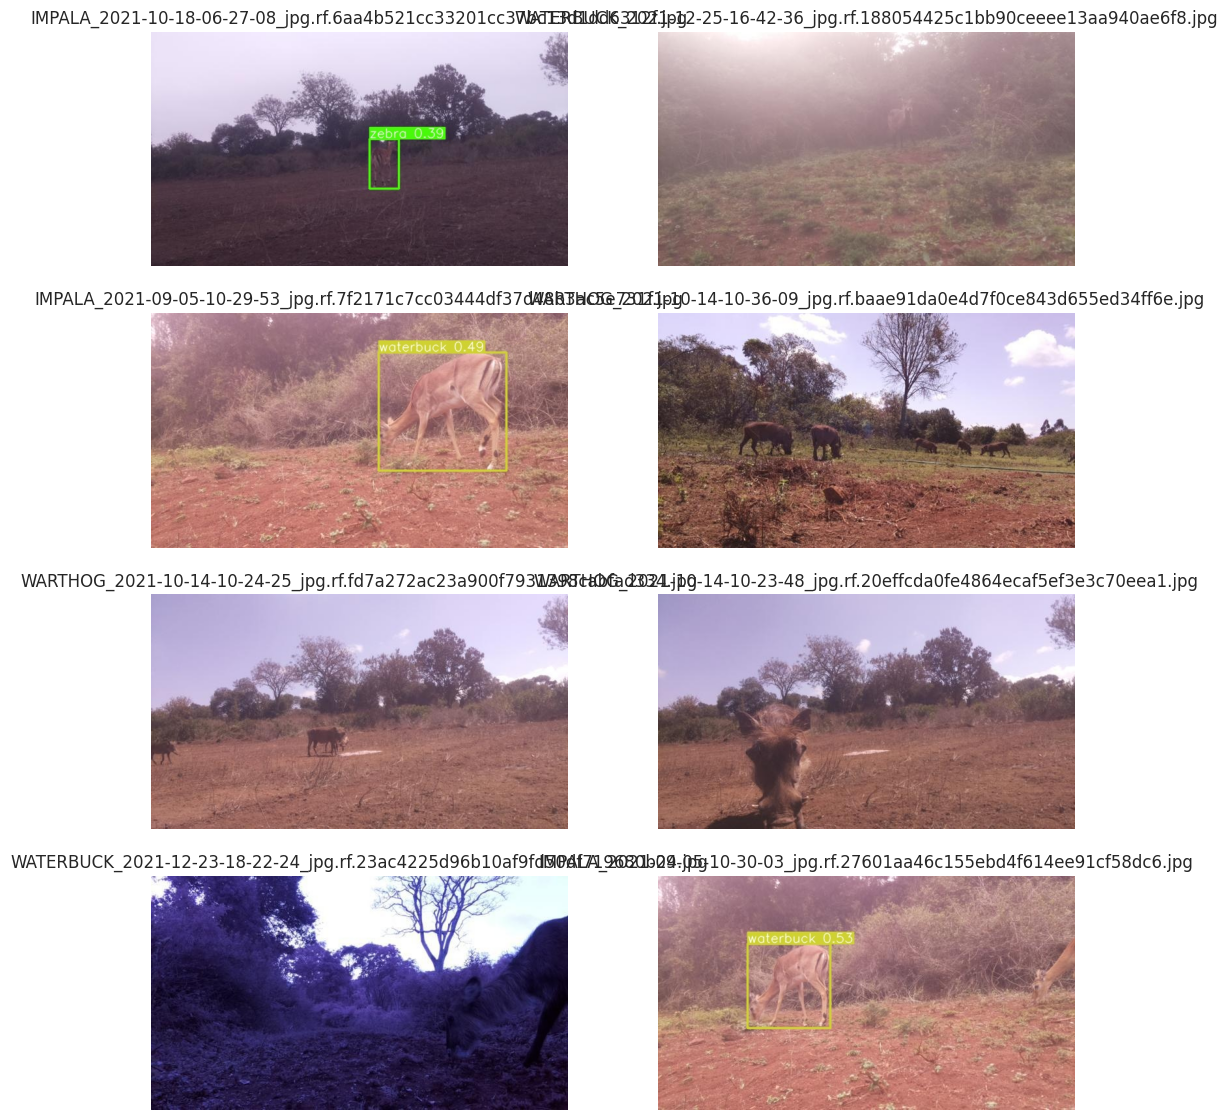

In [ ]:
visualize_directory_images('results', grid_size=(4,2))

The YOLO-World model misses a lot of the animals in the images. As shown above, it could only detect 3 animals from 8 images with at least 12 animals.
It also classified the bounding boxes into the wrong classes. This could be due to a failure of the model to understand our class names. Perhaps our model does not understand what a waterbuck is or maybe does not know how a waterbuck is supposed to look like.
We are going to retry the model with a more common and general term (such as `animal` or `mammal`) and see whether it performs better.

To ensure that we do not miss any predictions, we are going to change the minimum confidence threshold for a prediction to be accepted.
However, to compensate for the low confidence threshold we are also going to set a higher IoU threshold to avoid bounding box overlaps resulting from the same animal being detected multiple times. Thus we set the confidence threshold at 0.003 and iou at 0.1.

In [ ]:
model.set_classes(['mammal'])

In [ ]:
## Make predictions on the sample images
results = model.predict(sample_images, conf=0.003, iou=0.1)

## Save output images with bounding boxes in a folder
os.makedirs('results', exist_ok=True)
for result in results:
  result_path = os.path.join('results', os.path.basename(result.path))
  result.save(result_path)


0: 384x640 2 mammals, 9.2ms
1: 384x640 1 mammal, 9.2ms
2: 384x640 5 mammals, 9.2ms
3: 384x640 2 mammals, 9.2ms
4: 384x640 1 mammal, 9.2ms
5: 384x640 1 mammal, 9.2ms
6: 384x640 1 mammal, 9.2ms
7: 384x640 1 mammal, 9.2ms
8: 384x640 1 mammal, 9.2ms
Speed: 1.1ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


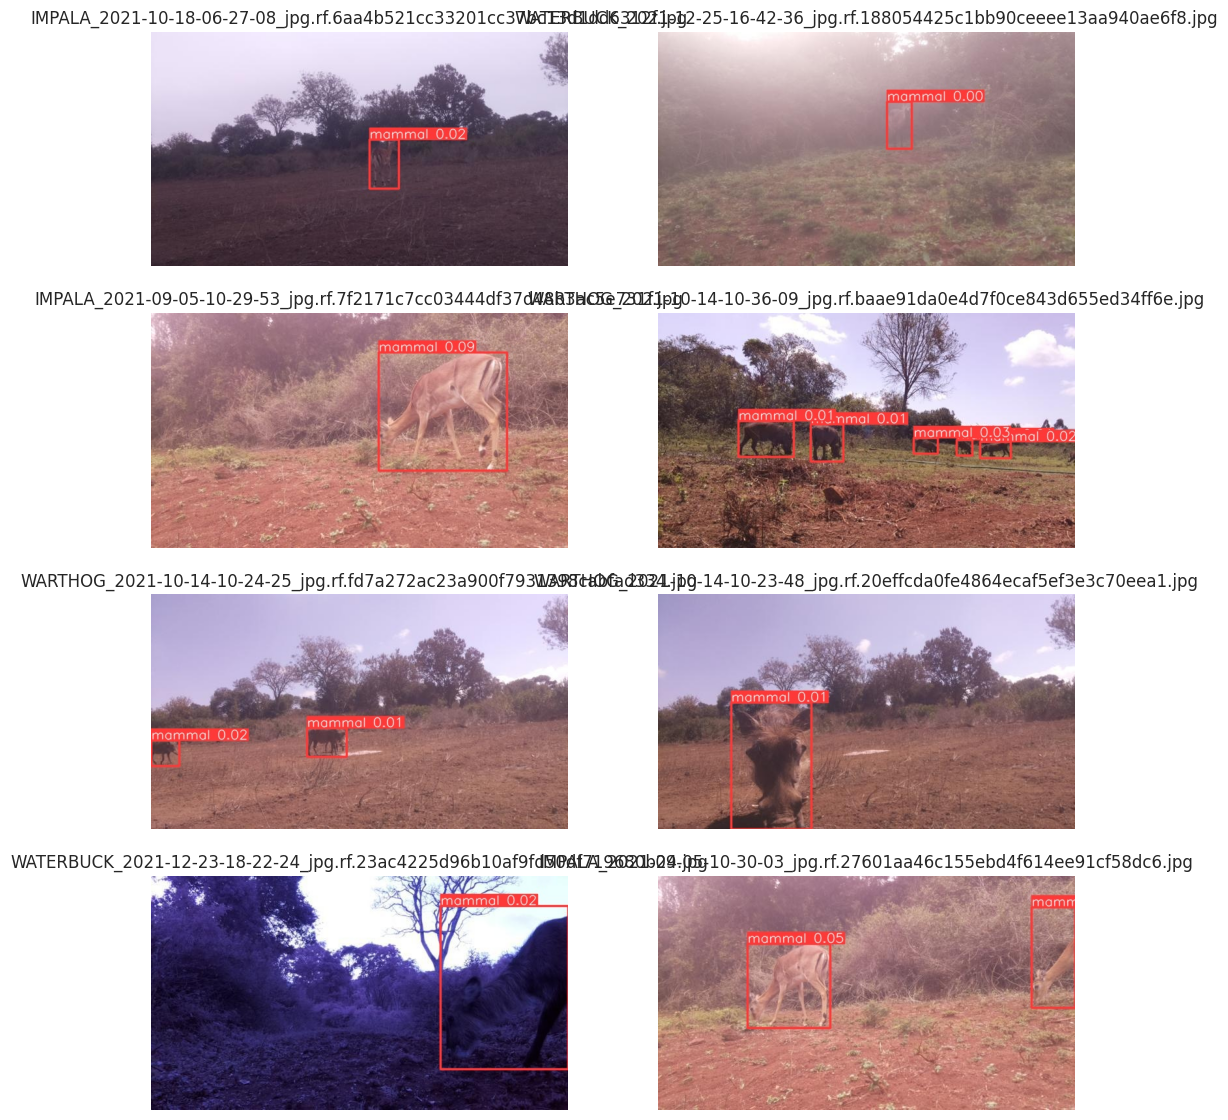

In [ ]:
visualize_directory_images('results', grid_size=(4,2))

The model now performs much better. It is able to detect all the animals in the 8 images accurately.

To summarize our experiment with the YOLO-World Model:

Many advances have been made in the area of open vocabulary detection. However, it still has many limitations such as :

  1. Limited Specificity: Open vocabulary models may struggle to detect and classify specific objects of rare or closely related categories accurately. They are typically trained on a diverse range of objects but may not have sufficient examples or fine-grained details to distinguish between closely related categories.

  2. Inference speed: Each image took more than an eighth of a second to be processed on the Colab CPU. This might not seem like much but will accumulate to huge processing times in case you are working with a lot of images or in case you are trying to run inference on a video. As you'll see later, YOLOv8 fine tuned models run inference at speeds upto 50 times faster.

  3. Large Model size: The CLIP model which is more than 300 MBs was downloaded in order for the zero-shot inference to be run.

### Exercise
In the accompanying [exercise notebook](https://colab.research.google.com/github/Marconi-Lab/dsa_2024/blob/main/dsa2024_yolov8_detection_exercises.ipynb) you will try out another zero-shot model such as [`Grounding Dino`](https://github.com/IDEA-Research/GroundingDINO) and compare its performance to YOLO-World


## Fine Tuning A Pre-Trained YOLO Model with Our Dataset

As we've seen in the previous section, zero-shot detection still has some limitations. To overcome some of these limitations, here we are going to fine tune a pre-trained YOLOv8 model with our own dataset. This way, the model will learn our classes and be able to make inference much faster than the zero-shot model.


First, we are going to install `Weights and Biases`. This tool will allow us to monitor and log our training process. It will also log our artefacts such as the final model and the parameters. This will allow us to compare different runs as we experiment with different model sizes, different hyperparameters and different augmentations.

To sign up, go to https://wandb.ai/site. After signing up, copy your API key and paste into to your Colab Secrets on the left pane.


In [ ]:
!pip install wandb &>1
import wandb

from google.colab import userdata
wandb_api = userdata.get('wandb_api')
wandb.login(key=wandb_api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
RUN_NAME = 'bounding-box-augmentation-run'
DATASET_PATH = '/content/dsail-porini-detection-v2-1/'

## Initialize wandb run
run = wandb.init(project='dsail-porini-detection', name=RUN_NAME)

## Save the README file that contains information about the augmentations done in roboflow
wandb.save(os.path.join(DATASET_PATH, 'README.roboflow.txt'))

wandb: Currently logged in as: vickruto. Use `wandb login --relogin` to force relogin


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


['/content/wandb/run-20240516_121100-qrtefih6/files/dsail-porini-detection-v2-1/README.roboflow.txt']

In [ ]:
## Load a pre-trained YOLO model (recommended for training)
## Model size variants include : ['yolov8n.pt', 'yolov8s.pt' 'yolov8m.pt', 'yolov8l.pt', 'yolov8x.pt']
model = YOLO('yolov8s.pt')

## Train the model
model.train(data=os.path.join(DATASET_PATH, 'dataset.yaml'),
            epochs=50,
            name = 'dsail-porini-detection',
            save_dir=f'runs/detect/{RUN_NAME}')

100%|██████████| 21.5M/21.5M [00:00<00:00, 298MB/s]


Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/dsail-porini-detection-v2-1/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=dsail-porini-detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False,

100%|██████████| 755k/755k [00:00<00:00, 80.2MB/s]

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           


  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  8                  -1  1   1838080  ultralytics.nn.modules.block.C2f             [512, 512, 1, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    591360  ultralytics.nn.modules.block.C2f             [768, 256, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384,

100%|██████████| 6.23M/6.23M [00:00<00:00, 79.1MB/s]


AMP: checks passed ✅


train: Scanning /content/dsail-porini-detection-v2-1/train/labels... 1047 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1047/1047 [00:01<00:00, 927.92it/s]

train: New cache created: /content/dsail-porini-detection-v2-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dsail-porini-detection-v2-1/valid/labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 568.55it/s]

val: New cache created: /content/dsail-porini-detection-v2-1/valid/labels.cache


Plotting labels to runs/detect/dsail-porini-detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/dsail-porini-detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.91G     0.8388      3.236      1.072         22        640: 100%|██████████| 66/66 [00:34<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all         70         94      0.881      0.769       0.87      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       4.2G     0.7635      1.293      1.052         19        640: 100%|██████████| 66/66 [00:29<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


                   all         70         94      0.425      0.406      0.409      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.14G     0.8032      1.155      1.054         13        640: 100%|██████████| 66/66 [00:29<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]

                   all         70         94      0.784      0.616      0.755      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.16G     0.7902      1.027      1.048         18        640: 100%|██████████| 66/66 [00:30<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]

                   all         70         94      0.649      0.688      0.758       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.14G     0.7357     0.9184      1.031         18        640: 100%|██████████| 66/66 [00:30<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


                   all         70         94      0.839      0.823      0.881      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.19G     0.7225     0.8312      1.024         25        640: 100%|██████████| 66/66 [00:29<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         70         94       0.75      0.742      0.846       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.16G     0.7015     0.7947      1.013         19        640: 100%|██████████| 66/66 [00:37<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all         70         94      0.896      0.836      0.895      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.18G     0.6658     0.7476      1.004         21        640: 100%|██████████| 66/66 [00:28<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

                   all         70         94      0.935      0.804      0.915      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.16G      0.651      0.667     0.9881         12        640: 100%|██████████| 66/66 [00:29<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]

                   all         70         94      0.924      0.841      0.914      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.19G     0.6401     0.6561     0.9846         15        640: 100%|██████████| 66/66 [00:28<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]

                   all         70         94      0.872       0.88      0.924      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.16G     0.6191     0.6177     0.9695         11        640: 100%|██████████| 66/66 [00:28<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         70         94      0.883      0.805      0.896      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.16G     0.6195     0.6202      0.981         17        640: 100%|██████████| 66/66 [00:28<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         70         94      0.879      0.908      0.927      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.16G     0.6123     0.6231     0.9715         16        640: 100%|██████████| 66/66 [00:29<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all         70         94      0.892       0.87      0.924      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.16G      0.579     0.5939     0.9578         24        640: 100%|██████████| 66/66 [00:28<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

                   all         70         94      0.943      0.868      0.915      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.16G      0.572     0.5456     0.9522         27        640: 100%|██████████| 66/66 [00:32<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all         70         94      0.939      0.884      0.935      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.19G      0.563     0.5439     0.9466         16        640: 100%|██████████| 66/66 [00:30<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


                   all         70         94      0.923      0.912      0.951       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.16G     0.5576     0.5375     0.9536         12        640: 100%|██████████| 66/66 [00:28<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         70         94      0.875      0.902      0.929      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.18G     0.5406     0.5109     0.9425         19        640: 100%|██████████| 66/66 [00:28<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all         70         94      0.919      0.925      0.954       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.16G     0.5391     0.5004      0.933         15        640: 100%|██████████| 66/66 [00:28<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

                   all         70         94      0.973      0.903      0.954      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.16G     0.5241     0.4759      0.932         15        640: 100%|██████████| 66/66 [00:28<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         70         94       0.95      0.912       0.95      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.16G      0.528     0.4803     0.9408         19        640: 100%|██████████| 66/66 [00:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]

                   all         70         94       0.94      0.937      0.974      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.18G     0.5115     0.4603     0.9261         22        640: 100%|██████████| 66/66 [00:28<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         70         94      0.953      0.925      0.974      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.17G     0.5186      0.475     0.9358         23        640: 100%|██████████| 66/66 [00:28<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         70         94      0.912      0.919      0.956      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.19G     0.5048     0.4412     0.9276         22        640: 100%|██████████| 66/66 [00:32<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         70         94      0.989      0.928      0.984      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.16G      0.492      0.433     0.9088         16        640: 100%|██████████| 66/66 [00:28<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         70         94      0.943      0.928      0.953      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.18G     0.4829     0.4165     0.9105         20        640: 100%|██████████| 66/66 [00:28<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         70         94      0.951      0.897       0.94      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.16G     0.4728      0.411       0.91         23        640: 100%|██████████| 66/66 [00:28<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all         70         94      0.923      0.916      0.938      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.19G     0.4666     0.3999     0.9154         18        640: 100%|██████████| 66/66 [00:27<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]

                   all         70         94      0.974      0.913      0.951       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.16G     0.4524     0.4067     0.9101         24        640: 100%|██████████| 66/66 [00:27<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.66it/s]

                   all         70         94       0.95      0.921      0.955      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.19G     0.4645     0.4013      0.907         11        640: 100%|██████████| 66/66 [00:28<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


                   all         70         94       0.95      0.926      0.951      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.16G      0.437     0.3792     0.9033         15        640: 100%|██████████| 66/66 [00:28<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all         70         94      0.951      0.927      0.951      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.16G      0.439      0.372     0.8933         20        640: 100%|██████████| 66/66 [00:27<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         70         94      0.943      0.913      0.964      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.16G     0.4256     0.3634     0.8911         13        640: 100%|██████████| 66/66 [00:28<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

                   all         70         94      0.972      0.921      0.957      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.16G     0.4223     0.3575     0.8845         20        640: 100%|██████████| 66/66 [00:30<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]

                   all         70         94      0.953      0.919      0.949      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.15G     0.4201     0.3661     0.8867         14        640: 100%|██████████| 66/66 [00:28<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]

                   all         70         94       0.93      0.906      0.952      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.18G     0.3935     0.3378     0.8709         14        640: 100%|██████████| 66/66 [00:28<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]

                   all         70         94      0.961      0.925      0.956      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.16G     0.3954     0.3221      0.882         15        640: 100%|██████████| 66/66 [00:29<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


                   all         70         94      0.927      0.926      0.969      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.18G      0.395     0.3309     0.8802         19        640: 100%|██████████| 66/66 [00:27<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         70         94      0.975       0.92      0.958      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.16G     0.3834     0.3239     0.8774         15        640: 100%|██████████| 66/66 [00:28<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         70         94      0.936      0.936      0.947      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.18G     0.3812     0.3225      0.881         17        640: 100%|██████████| 66/66 [00:27<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

                   all         70         94      0.954       0.93      0.946      0.777


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.16G     0.3678     0.2926     0.8528         10        640: 100%|██████████| 66/66 [00:28<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.26it/s]

                   all         70         94      0.942      0.929      0.951      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.18G      0.356     0.2572     0.8355          9        640: 100%|██████████| 66/66 [00:29<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all         70         94      0.979      0.909       0.96      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.16G     0.3491     0.2506     0.8435         11        640: 100%|██████████| 66/66 [00:27<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         70         94      0.988      0.922      0.963      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.19G     0.3382     0.2389     0.8354          9        640: 100%|██████████| 66/66 [00:26<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all         70         94      0.948      0.943      0.961      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.16G     0.3294     0.2283     0.8333          7        640: 100%|██████████| 66/66 [00:26<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         70         94      0.983      0.971      0.987      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.16G     0.3305     0.2329     0.8324         11        640: 100%|██████████| 66/66 [00:26<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

                   all         70         94      0.973      0.972      0.987      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.16G      0.317     0.2198     0.8343          8        640: 100%|██████████| 66/66 [00:26<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


                   all         70         94       0.95      0.942      0.959      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.18G     0.3169     0.2228     0.8363          8        640: 100%|██████████| 66/66 [00:26<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

                   all         70         94      0.947      0.942      0.958      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.16G     0.3047     0.2136      0.827          7        640: 100%|██████████| 66/66 [00:27<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]

                   all         70         94      0.946      0.939      0.958      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.18G     0.3059     0.2128     0.8305          9        640: 100%|██████████| 66/66 [00:27<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]

                   all         70         94      0.947       0.94      0.957       0.79



50 epochs completed in 0.453 hours.
Optimizer stripped from runs/detect/dsail-porini-detection/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/dsail-porini-detection/weights/best.pt, 22.5MB

Validating runs/detect/dsail-porini-detection/weights/best.pt...
Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11127906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


                   all         70         94      0.943      0.913      0.964      0.794
              bushbuck         70          9      0.945          1      0.995      0.814
                impala         70         17      0.994          1      0.995      0.852
                monkey         70          6      0.823      0.784      0.875      0.684
               warthog         70         22          1      0.944      0.986      0.808
             waterbuck         70         23          1       0.87      0.995      0.855
                 zebra         70         17      0.895      0.882      0.937      0.753
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/dsail-porini-detection


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a6ada0bd420>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

### Check the detection metrics on the validation and test sets

In [ ]:
val_results = model.val()

Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11127906 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/dsail-porini-detection-v2-1/valid/labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


                   all         70         94      0.943      0.913      0.964      0.796
              bushbuck         70          9      0.945          1      0.995      0.814
                impala         70         17      0.994          1      0.995      0.845
                monkey         70          6      0.823      0.784      0.875      0.684
               warthog         70         22          1      0.944      0.986      0.813
             waterbuck         70         23          1       0.87      0.995      0.859
                 zebra         70         17      0.895      0.882      0.937       0.76
Speed: 1.0ms preprocess, 36.2ms inference, 0.0ms loss, 6.9ms postprocess per image
Results saved to runs/detect/dsail-porini-detection2


In [ ]:
print(f"Validation split map50_95 score : {val_results.box.map:.3f}")
print(f"Validation split map50 score : {val_results.box.map50:.3f}")
print(f"Validation split map75 score : {val_results.box.map75:.3f}")

Validation split map50_95 score : 0.796
Validation split map50 score : 0.964
Validation split map75 score : 0.896


In [ ]:
test_results = model.val(split='test')

Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/dsail-porini-detection-v2-1/test/labels... 46 images, 0 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<00:00, 762.61it/s]

val: New cache created: /content/dsail-porini-detection-v2-1/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


                   all         46         60      0.958      0.921      0.958      0.741
              bushbuck         46          8      0.933       0.75      0.866      0.688
                impala         46          9      0.995          1      0.995      0.817
                monkey         46          3      0.967          1      0.995      0.632
               warthog         46          9      0.955      0.889      0.961      0.724
             waterbuck         46         22      0.907      0.888      0.933      0.752
                 zebra         46          9      0.992          1      0.995      0.833
Speed: 0.7ms preprocess, 21.6ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to runs/detect/dsail-porini-detection3


In [ ]:
print(f"Test split map50_95 score : {test_results.box.map:.3f}")
print(f"Test split map50 score : {test_results.box.map50:.3f}")
print(f"Test split map75 score : {test_results.box.map75:.3f}")

Test split map50_95 score : 0.741
Test split map50 score : 0.958
Test split map75 score : 0.809


In [ ]:
from pathlib import Path
images = sorted(Path.rglob(Path('/content/dsail-porini-detection-v2-1/test/images'), '*.jpg'))
sample_test_images = random.sample(images, 9)

In [ ]:
## Make predictions on the sample images
results = model.predict(sample_test_images)

## Save output images with bounding boxes in a folder
os.makedirs('test_results', exist_ok=True)
for result in results:
  result_path = os.path.join('test_results', os.path.basename(result.path))
  result.save(result_path)


0: 640x640 1 waterbuck, 17.7ms
1: 640x640 1 waterbuck, 17.7ms
2: 640x640 1 bushbuck, 17.7ms
3: 640x640 1 warthog, 17.7ms
4: 640x640 1 warthog, 1 waterbuck, 17.7ms
5: 640x640 2 waterbucks, 17.7ms
6: 640x640 1 waterbuck, 17.7ms
7: 640x640 3 warthogs, 17.7ms
8: 640x640 1 waterbuck, 17.7ms
Speed: 5.3ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


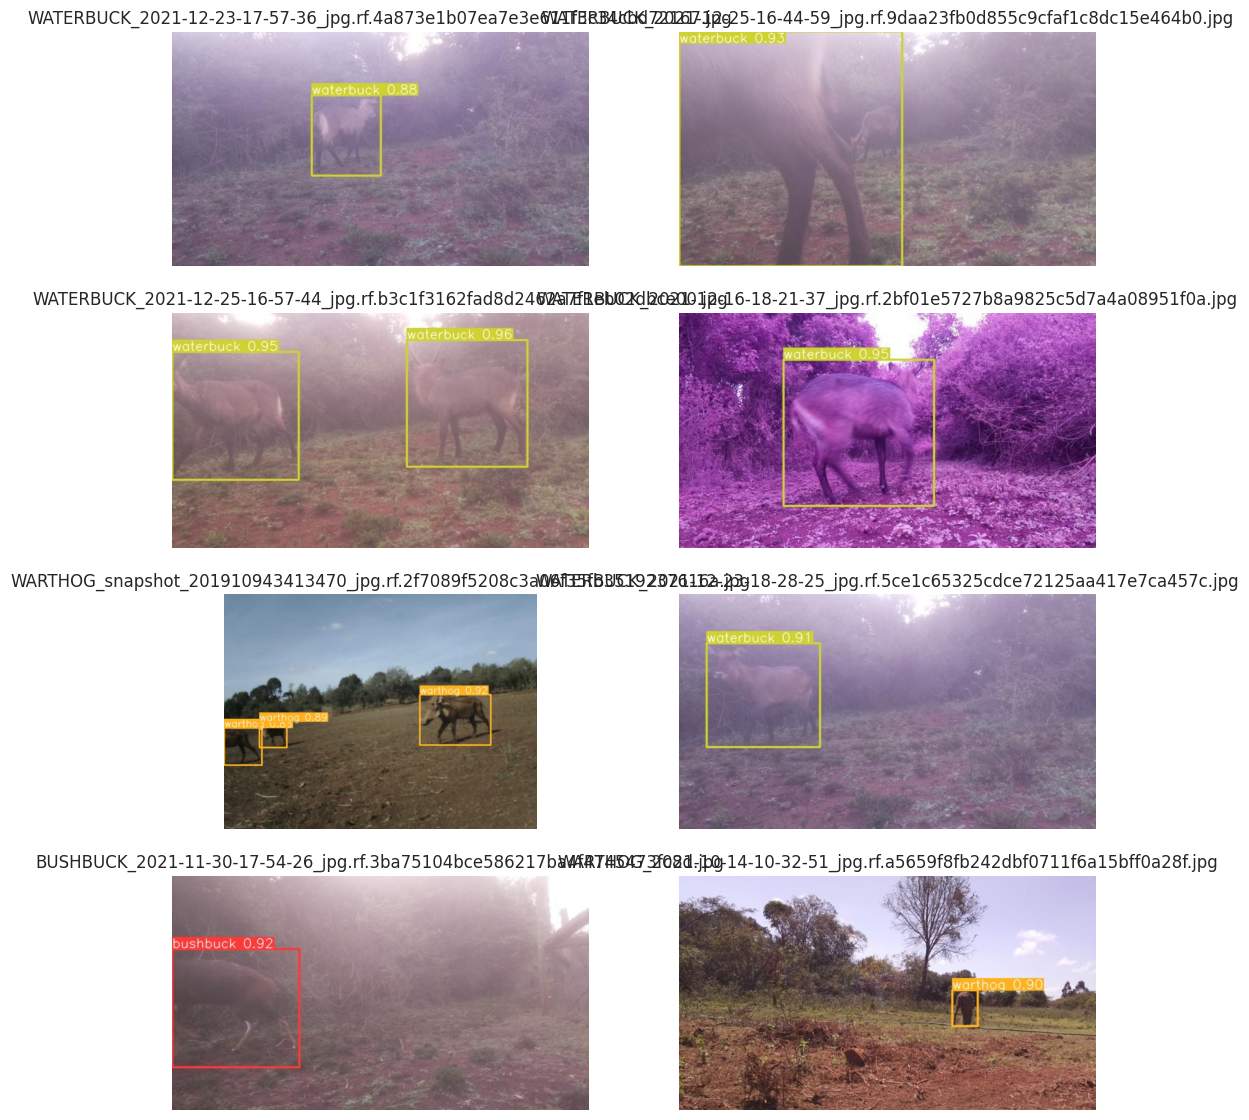

In [ ]:
visualize_directory_images('test_results', grid_size=(4,2))

### Visualize model predictions on the entire test set

With Fiftyone, you can visualize the model predictions and drill down to characterize the model. You can filter the predictions to only visualize true positives, false negatives or false positives. You can also filter by the confidence or iou threshold and by predicted or ground-truth class. You can also combine filters. This can enable you to identify instances where the model fails and help you to identify classes you may need to collect more data or what kind of augmentations you may apply to help the model.

In [69]:
from IPython.display import Video
Video("https://raw.githubusercontent.com/Marconi-Lab/dsa_2024/main/assets/fiftyone-screencast-2.webm")

In [ ]:
test_dataset.apply_model(model)

 100% |███████████████████| 46/46 [2.4s elapsed, 0s remaining, 21.8 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 46/46 [2.4s elapsed, 0s remaining, 21.8 samples/s]      


In [ ]:
## Evaluate the objects in the `predictions` field with respect to the objects in the `ground_truth` field
results = test_dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval_predictions",
)

Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████████| 46/46 [534.3ms elapsed, 0s remaining, 86.1 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 46/46 [534.3ms elapsed, 0s remaining, 86.1 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████████| 46/46 [874.4ms elapsed, 0s remaining, 52.6 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 46/46 [874.4ms elapsed, 0s remaining, 52.6 samples/s]      


In [ ]:
results.plot_confusion_matrix()

/usr/local/lib/python3.10/dist-packages/fiftyone/core/plots/plotly.py:1580: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



In [ ]:
results.print_report()

              precision    recall  f1-score   support

    bushbuck       0.86      0.75      0.80         8
      impala       1.00      1.00      1.00         9
      monkey       0.75      1.00      0.86         3
     warthog       0.75      1.00      0.86         9
   waterbuck       0.95      0.91      0.93        22
       zebra       1.00      1.00      1.00         9

   micro avg       0.90      0.93      0.92        60
   macro avg       0.88      0.94      0.91        60
weighted avg       0.91      0.93      0.92        60



In [ ]:
## Launch a new session to visualize the predictions
test_session = fo.launch_app(test_dataset)
test_session.show()

### Exercise :
In the accompanying [exercise notebook](https://colab.research.google.com/github/Marconi-Lab/dsa_2024/blob/main/dsa2024_yolov8_detection_exercises.ipynb) you will upload a few unannotated images available on Github to Roboflow and annotate them

You will then try out different combinations of the augmentations available on Roboflow to generate new datasets with the augmentations and use them to train new models. You will then compare the results on the test and validation sets with the augmentations we have used here.

Go ahead and open the exercise notebook. <a target="_blank" href="https://colab.research.google.com/github/Marconi-Lab/dsa_2024/blob/main/dsa2024_yolov8_detection_exercises.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>